In [5]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parents[0]
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

print("Using src from:", SRC_PATH)

Using src from: C:\Users\LO79RS\HFD_Project\src


In [6]:
from io_utils import load_data
from config import CONTRACTS

### Strategy 1 (EMA(20)-EMA(240))
Asset: SP (S&P futures)
- Position space: long / short / flat

Trend definition:
- EMA(20) - EMA(240)

Filter:
- Volatility-scaled threshold using 30-minute rolling std

Interpretation:
- Trade only when the trend signal is strong relative to recent market noise.


In [7]:
import numpy as np
import pandas as pd

G1_TRADE_DIR = Path("../data_processed/group1/trade")
g1_files = sorted(G1_TRADE_DIR.glob("*.parquet"))

sample_file = g1_files[0]
df = load_data(str(sample_file))

# Focus on a single liquid contract
price = df["SP"].astype(float).dropna()

print("Using file:", sample_file.name)
print("Price rows:", price.shape[0])
price.head()

Using file: data1_2023_Q1.parquet
Price rows: 23120


datetime
2023-01-03 09:56:00+00:00    3838.926
2023-01-03 09:57:00+00:00    3837.926
2023-01-03 09:58:00+00:00    3835.875
2023-01-03 09:59:00+00:00    3832.116
2023-01-03 10:00:00+00:00    3831.176
Name: SP, dtype: float64

Strategy parameters (SP, EMA, 30-min rule)

In [8]:
ASSET = "SP"
POINT_VALUE = 50
TCOST_PER_TRADE = 12
TRADING_DAYS = 252

# EMA settings
EMA_FAST = 20
EMA_SLOW = 240

# Position rule
# We want long/short/flat based on EMA spread
BAND = 0.0  

# Trading rule: minimum holding period before switching position
MIN_HOLD = "30min"

In [9]:
# Use one quarter first to validate end-to-end
G1_TRADE_DIR = Path("../data_processed/group1/trade")
g1_trade_files = sorted(G1_TRADE_DIR.glob("*.parquet"))

sample_file = g1_trade_files[0]
df = load_data(str(sample_file))

price = df[ASSET].astype(float).dropna().sort_index()

ema_fast = price.ewm(span=EMA_FAST, adjust=False).mean()
ema_slow = price.ewm(span=EMA_SLOW, adjust=False).mean()

spread = ema_fast - ema_slow

print("Using file:", sample_file.name)
print("Price rows:", len(price), "from", price.index.min(), "to", price.index.max())

Using file: data1_2023_Q1.parquet
Price rows: 23120 from 2023-01-03 09:56:00+00:00 to 2023-03-31 16:00:00+00:00


Raw signal: long/short/flat

In [10]:
VOL_WIN = 120
K_ENTER = 10
K_EXIT  = 5


ret = price.pct_change()
vol = ret.rolling(VOL_WIN).std()

enter_band = K_ENTER * vol
exit_band  = K_EXIT  * vol

raw_pos = np.where(spread > enter_band, 1,
          np.where(spread < -enter_band, -1, 0))
raw_pos = pd.Series(raw_pos, index=price.index).fillna(0).astype(int)


pos = raw_pos.copy()
pos.iloc[:] = 0

for i in range(1, len(pos)):
    prev = pos.iat[i-1]
    s = spread.iat[i]
    eb = exit_band.iat[i]

    # If raw signal says enter, do it
    if raw_pos.iat[i] != 0:
        pos.iat[i] = raw_pos.iat[i]
    else:
        # Otherwise, keep position unless signal weak enough to exit
        if prev == 1 and s < eb:
            pos.iat[i] = 0
        elif prev == -1 and s > -eb:
            pos.iat[i] = 0
        else:
            pos.iat[i] = prev

In [11]:
pos = raw_pos.astype(int)

In [12]:
n_flips = (pos.diff().fillna(0) != 0).sum()
print("Position changes:", int(n_flips))

Position changes: 142


In [13]:
# --- Flip diagnostics (1-min data) ---

# Ensure pos is a clean int series (in case it isn't yet)
pos = pos.astype(int)

# Previous and current position at each timestamp
prev_pos = pos.shift(1)
curr_pos = pos

# Rows where position changed
flip_mask = curr_pos.ne(prev_pos)
flips = pd.DataFrame({"prev": prev_pos[flip_mask], "curr": curr_pos[flip_mask]}).dropna()

# Count flip types
flip_counts = flips.value_counts().sort_values(ascending=False)
print("Flip types (prev -> curr) counts:")
print(flip_counts)

# Summary buckets
n_total = int(flip_mask.sum())
n_long_to_short = int(((prev_pos == 1) & (curr_pos == -1)).sum())
n_short_to_long = int(((prev_pos == -1) & (curr_pos == 1)).sum())
n_enter = int(((prev_pos == 0) & (curr_pos != 0)).sum())
n_exit  = int(((prev_pos != 0) & (curr_pos == 0)).sum())

print("\nSummary:")
print("Total flips:", n_total)
print("Long -> Short:", n_long_to_short)
print("Short -> Long:", n_short_to_long)
print("Enter (0 -> +/-1):", n_enter)
print("Exit (+/-1 -> 0):", n_exit)

Flip types (prev -> curr) counts:
prev  curr
-1.0   1      64
 1.0  -1      63
 0.0  -1       4
       1       4
 1.0   0       4
-1.0   0       3
Name: count, dtype: int64

Summary:
Total flips: 143
Long -> Short: 63
Short -> Long: 64
Enter (0 -> +/-1): 8
Exit (+/-1 -> 0): 8


PnL backbone (1-minute, position shifted)

In [14]:
# 1-minute price changes (in index points)
dP = price.diff()

# Use previous bar's position to trade the next bar (avoid look-ahead)
pos_lag = pos.shift(1).fillna(0).astype(int)

# Gross PnL in index points
pnl_points = pos_lag * dP

pnl_points.describe()

count    23119.000000
mean         0.006316
std          2.199464
min        -63.973000
25%         -0.506000
50%          0.000000
75%          0.554000
max         55.590000
dtype: float64

In [15]:
# Aggregate 1-minute PnL to daily gross PnL
pnl_daily = pnl_points.resample("1D").sum()

print("Daily gross PnL summary:")
print(pnl_daily.describe())

Daily gross PnL summary:
count     88.000000
mean       1.659227
std       38.852873
min     -122.705000
25%       -6.289000
50%        0.000000
75%       26.018250
max       72.263000
dtype: float64


In [16]:
prev_pos = pos.shift(1).fillna(0).astype(int)

# each position change = 1 transaction "unit" in your implementation
tx_1m = (pos - prev_pos).abs()

# NOTE: if you ever allow direct +1 -> -1 flips, abs gives 2 (two transactions) which is fine.
tx_daily1 = tx_1m.resample("1D").sum().rename("tx_daily")

tx_daily1.describe(), tx_daily1.sum()

(count    88.000000
 mean      3.056818
 std       4.144954
 min       0.000000
 25%       0.000000
 50%       2.000000
 75%       4.000000
 max      22.000000
 Name: tx_daily, dtype: float64,
 np.int64(269))

In [17]:
pnl_daily_gross_usd1= (pnl_daily * POINT_VALUE).rename("pnl_daily_gross_usd")

cost_daily_usd1 = (tx_daily1 * TCOST_PER_TRADE).rename("cost_daily_usd")

pnl_daily_net_usd1 = (pnl_daily_gross_usd1 - cost_daily_usd1).rename("pnl_daily_net_usd")

pnl_daily_gross_usd1.describe(), pnl_daily_net_usd1.describe()

(count      88.000000
 mean       82.961364
 std      1942.643640
 min     -6135.250000
 25%      -314.450000
 50%         0.000000
 75%      1300.912500
 max      3613.150000
 Name: pnl_daily_gross_usd, dtype: float64,
 count      88.000000
 mean       46.279545
 std      1972.010105
 min     -6207.250000
 25%      -368.450000
 50%         0.000000
 75%      1263.937500
 max      3613.150000
 Name: pnl_daily_net_usd, dtype: float64)

After transaction costs the strategy remains profitable.

#### Strategy 2

Strategy parameters (SP, EMA(20)-EMA(60), 30-min rule)

In [18]:
ASSET = "SP"

# EMA settings
EMA_FAST_S2 = 20
EMA_SLOW_S2 = 60

# Position rule
# We want long/short/flat based on EMA spread
BAND_S2 = 0.0  

# Trading rule: minimum holding period before switching position
MIN_HOLD = "30min"

In [19]:
ema_fast_s2 = price.ewm(span=EMA_FAST_S2, adjust=False).mean()
ema_slow_s2 = price.ewm(span=EMA_SLOW_S2, adjust=False).mean()

spread = ema_fast_s2- ema_slow_s2

Raw signal: long/short/flat

In [20]:
VOL_WIN_S2 = 120
K_ENTER_S2 = 2
K_EXIT_S2  = 0.8

ret = price.pct_change()
vol2 = ret.rolling(VOL_WIN_S2).std()

enter_band2 = K_ENTER_S2 * vol
exit_band2  = K_EXIT_S2  * vol

raw_pos2= np.where(spread > enter_band, 1,
          np.where(spread < -enter_band, -1, 0))
raw_pos2 = pd.Series(raw_pos2, index=price.index).fillna(0).astype(int)

# Build position with hysteresis (enter strong, exit weak)
pos2 = raw_pos2.copy()
pos2.iloc[:] = 0

for i in range(1, len(pos2)):
    prev = pos2.iat[i-1]
    s = spread.iat[i]
    eb = exit_band.iat[i]

    # If raw signal says enter, do it
    if raw_pos2.iat[i] != 0:
        pos2.iat[i] = raw_pos2.iat[i]
    else:
        # Otherwise, keep position unless signal weak enough to exit
        if prev == 1 and s < eb:
            pos2.iat[i] = 0
        elif prev == -1 and s > -eb:
            pos2.iat[i] = 0
        else:
            pos2.iat[i] = prev

In [21]:
pos2 = raw_pos2.astype(int)

In [22]:
n_flips = (pos2.diff().fillna(0) != 0).sum()
print("Position changes:", int(n_flips))

Position changes: 297


In [23]:
# --- Flip diagnostics (1-min data) ---

# Ensure pos is a clean int series (in case it isn't yet)
pos2 = pos2.astype(int)

# Previous and current position at each timestamp
prev_pos2 = pos2.shift(1)
curr_pos2 = pos2

# Rows where position changed
flip_mask2 = curr_pos2.ne(prev_pos2)
flips2 = pd.DataFrame({"prev": prev_pos2[flip_mask2], "curr": curr_pos2[flip_mask2]}).dropna()

# Count flip types
flip_counts2 = flips2.value_counts().sort_values(ascending=False)
print("Flip types (prev -> curr) counts:")
print(flip_counts2)

# Summary buckets
n_total2 = int(flip_mask2.sum())
n_long_to_short2 = int(((prev_pos2 == 1) & (curr_pos2 == -1)).sum())
n_short_to_long2 = int(((prev_pos2 == -1) & (curr_pos2 == 1)).sum())
n_enter2 = int(((prev_pos2 == 0) & (curr_pos2 != 0)).sum())
n_exit2  = int(((prev_pos2 != 0) & (curr_pos2 == 0)).sum())

print("\nSummary:")
print("Total flips:", n_total2)
print("Long -> Short:", n_long_to_short2)
print("Short -> Long:", n_short_to_long2)
print("Enter (0 -> +/-1):", n_enter2)
print("Exit (+/-1 -> 0):", n_exit2)

Flip types (prev -> curr) counts:
prev  curr
-1.0   1      137
 1.0  -1      137
-1.0   0        6
 0.0  -1        6
       1        6
 1.0   0        5
Name: count, dtype: int64

Summary:
Total flips: 298
Long -> Short: 137
Short -> Long: 137
Enter (0 -> +/-1): 12
Exit (+/-1 -> 0): 12


PnL backbone (1-minute, position shifted)

In [24]:
# 1-minute price changes (in index points)
dP = price.diff()

# Use previous bar's position to trade the next bar (avoid look-ahead)
pos_lag2 = pos2.shift(1).fillna(0).astype(int)

# Gross PnL in index points
pnl_points2 = pos_lag2* dP

pnl_points2.describe()

count    23119.000000
mean         0.004973
std          2.199458
min        -63.973000
25%         -0.510000
50%          0.000000
75%          0.531000
max         55.590000
dtype: float64

In [25]:
# Aggregate 1-minute PnL to daily gross PnL
pnl_daily2 = pnl_points2.resample("1D").sum()

print("Daily gross PnL summary:")
print(pnl_daily2.describe())

Daily gross PnL summary:
count     88.000000
mean       1.306500
std       37.466098
min     -111.039000
25%       -9.510500
50%        0.000000
75%       23.171500
max       78.252000
dtype: float64


In [26]:
prev_pos2 = pos2.shift(1).fillna(0).astype(int)

# each position change = 1 transaction "unit" in your implementation
tx_1m = (pos2 - prev_pos2).abs()

# NOTE: if you ever allow direct +1 -> -1 flips, abs gives 2 (two transactions) which is fine.
tx_daily = tx_1m.resample("1D").sum().rename("tx_daily")

tx_daily.describe(), tx_daily.sum()

(count    88.000000
 mean      6.488636
 std       6.019116
 min       0.000000
 25%       0.000000
 50%       6.000000
 75%      10.000000
 max      22.000000
 Name: tx_daily, dtype: float64,
 np.int64(571))

In [27]:
pnl_daily_gross_usd= (pnl_daily2 * POINT_VALUE).rename("pnl_daily_gross_usd")

cost_daily_usd = (tx_daily * TCOST_PER_TRADE).rename("cost_daily_usd")

pnl_daily_net_usd = (pnl_daily_gross_usd - cost_daily_usd).rename("pnl_daily_net_usd")

pnl_daily_gross_usd.describe(), pnl_daily_net_usd.describe()

(count      88.000000
 mean       65.325000
 std      1873.304904
 min     -5551.950000
 25%      -475.525000
 50%         0.000000
 75%      1158.575000
 max      3912.600000
 Name: pnl_daily_gross_usd, dtype: float64,
 count      88.000000
 mean      -12.538636
 std      1907.905968
 min     -5815.950000
 25%      -601.750000
 50%         0.000000
 75%      1068.887500
 max      3840.600000
 Name: pnl_daily_net_usd, dtype: float64)

In [28]:
# --- Strategy comparison table (S1 vs S2) ---
# Compare daily PnL statistics for two parameter sets of the same strategy

def summarize_daily_pnl(pnl_daily, label):
    return pd.Series({
        "mean_daily_pnl": pnl_daily.mean(),
        "std_daily_pnl": pnl_daily.std(),
        "sharpe_daily": (
            pnl_daily.mean() / pnl_daily.std()
            if pnl_daily.std() != 0 else np.nan
        ),
        "min_daily_pnl": pnl_daily.min(),
        "max_daily_pnl": pnl_daily.max(),
        "positive_days_%": (pnl_daily > 0).mean() * 100,
        "num_days": pnl_daily.count()
    }, name=label)

# Build comparison table
summary_s1 = summarize_daily_pnl(pnl_daily, "EMA(20)-EMA(240) S1")
summary_s2 = summarize_daily_pnl(pnl_daily2, "EMA(20)-EMA(60) S2")

comparison_table = pd.concat([summary_s1, summary_s2], axis=1)

print("Strategy comparison (daily PnL based):")
comparison_table

Strategy comparison (daily PnL based):


,EMA(20)-EMA(240) S1,EMA(20)-EMA(60) S2
mean_daily_pnl,1.659227,1.306500
std_daily_pnl,38.852873,37.466098
sharpe_daily,0.042705,0.034872
min_daily_pnl,-122.705000,-111.039000
max_daily_pnl,72.263000,78.252000
positive_days_%,42.045455,42.045455
num_days,88.000000,88.000000


EMA(20)-EMA(240) performed better compared to EMA(20)-EMA(60) both in daily net PnL ($) and simple metrics above. So, we will move forward with applying EMA(20)-EMA(240) to all quarter.

QUARTER LOOP

In [29]:
from pathlib import Path
import re

PROJECT_ROOT = Path.cwd().resolve().parents[0]   # notebooks/ -> project root
G1_TRADE_DIR = PROJECT_ROOT / "data_processed" / "group1" / "trade"

files = sorted(G1_TRADE_DIR.glob("*.parquet"))
print("Num quarter files:", len(files))
print("First 10:", [f.name for f in files[:10]])

pat = re.compile(r"(\d{4})_Q([1-4])")
quarters = []
for f in files:
    m = pat.search(f.name)
    if m:
        year = int(m.group(1))
        q = int(m.group(2))
        quarters.append({"file": str(f), "year": year, "quarter": q, "label": f"{year}_Q{q}"})

quarter_df = pd.DataFrame(quarters).sort_values(["year","quarter"]).reset_index(drop=True)
quarter_df

Num quarter files: 7
First 10: ['data1_2023_Q1.parquet', 'data1_2023_Q3.parquet', 'data1_2023_Q4.parquet', 'data1_2024_Q2.parquet', 'data1_2024_Q4.parquet', 'data1_2025_Q1.parquet', 'data1_2025_Q2.parquet']


,file,year,quarter,label
0,C:\Users\LO79RS\HFD_Project\data_processed\gro...,2023,1,2023_Q1
1,C:\Users\LO79RS\HFD_Project\data_processed\gro...,2023,3,2023_Q3
2,C:\Users\LO79RS\HFD_Project\data_processed\gro...,2023,4,2023_Q4
3,C:\Users\LO79RS\HFD_Project\data_processed\gro...,2024,2,2024_Q2
4,C:\Users\LO79RS\HFD_Project\data_processed\gro...,2024,4,2024_Q4
5,C:\Users\LO79RS\HFD_Project\data_processed\gro...,2025,1,2025_Q1
6,C:\Users\LO79RS\HFD_Project\data_processed\gro...,2025,2,2025_Q2


In [30]:
test_row = quarter_df.iloc[0]
test_label = test_row["label"]
test_file  = test_row["file"]

df = pd.read_parquet(test_file)

print("Quarter:", test_label)
print("File:", test_file)
print("df.shape:", df.shape)
print("df.columns:", df.columns.tolist())
print("index type:", type(df.index))


price = df["SP"].astype(float).dropna().sort_index()

print("\nSP clean rows:", len(price))
print("Start:", price.index.min(), "| End:", price.index.max())
price.head()

Quarter: 2023_Q1
File: C:\Users\LO79RS\HFD_Project\data_processed\group1\trade\data1_2023_Q1.parquet
df.shape: (23484, 2)
df.columns: ['NQ', 'SP']
index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

SP clean rows: 23120
Start: 2023-01-03 09:56:00+00:00 | End: 2023-03-31 16:00:00+00:00


datetime
2023-01-03 09:56:00+00:00    3838.926
2023-01-03 09:57:00+00:00    3837.926
2023-01-03 09:58:00+00:00    3835.875
2023-01-03 09:59:00+00:00    3832.116
2023-01-03 10:00:00+00:00    3831.176
Name: SP, dtype: float64

In [31]:
def annualized_sharpe(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2:
        return np.nan
    vol = x.std(ddof=0)
    if vol == 0:
        return np.nan
    return (x.mean() / vol) * np.sqrt(TRADING_DAYS)

In [32]:
def calmar_ratio(pnl_daily, freq=252):
    if pnl_daily.std() == 0:
        return np.nan

    # cumulative PnL
    cum = pnl_daily.cumsum()

    # drawdown
    running_max = cum.cummax()
    drawdown = cum - running_max
    max_dd = drawdown.min()

    if max_dd == 0:
        return np.nan

    annual_return = pnl_daily.mean() * freq
    return annual_return / abs(max_dd)

In [33]:
def run_ema_crossover(
    df: pd.DataFrame,
    asset: str = "SP",
    ema_fast: int = 20,
    ema_slow: int = 240,
    vol_win: int = 120,
    k_enter: float = 10,
    k_exit: float = 5,
    point_value: float = 50.0,
    tcost_per_trade: float = 12.0,
) -> dict:
    """
    EMA(ema_fast)-EMA(ema_slow) trend-following with volatility-scaled strength bands.
    - strength = |ema_fast - ema_slow| / price
    - vol      = rolling std of returns
    - enter when strength >= k_enter * vol (and direction != 0)
    - exit  when strength <= k_exit  * vol OR direction flips
    Returns daily gross/net PnL in USD and trade counts.
    """

    # --- Price series ---
    price = df[asset].astype(float).dropna().sort_index()
    if len(price) < max(ema_slow, vol_win) + 5:
        # Not enough data to compute indicators reliably
        empty = pd.Series(dtype=float)
        return {
            "pnl_daily_gross_usd": empty,
            "pnl_daily_net_usd": empty,
            "trades_daily": empty,
            "pos": pd.Series(dtype=int),
        }

    # --- EMAs ---
    ema_f = price.ewm(span=ema_fast, adjust=False).mean()
    ema_s = price.ewm(span=ema_slow, adjust=False).mean()

    # Direction: +1 if fast>slow, -1 if fast<slow, 0 if equal (rare)
    dir_raw = np.sign(ema_f - ema_s)
    dir_raw = pd.Series(dir_raw, index=price.index).replace(0, np.nan).ffill().fillna(0).astype(int)

    # --- Strength (normalized by price) ---
    strength = (ema_f - ema_s).abs() / price

    # --- Volatility band (same scale as strength, since vol is std of returns) ---
    ret = price.pct_change()
    vol = ret.rolling(vol_win).std()

    enter_band = (k_enter * vol)
    exit_band  = (k_exit  * vol)

    # Block trading until vol exists (avoid NaNs)
    enter_band = enter_band.fillna(np.inf)   # cannot enter before vol is defined
    exit_band  = exit_band.fillna(-np.inf)   # cannot exit by band before vol is defined

    # --- Persistent position with hysteresis ---
    pos = pd.Series(0, index=price.index, dtype=int)
    state = 0  # 0 flat, +1 long, -1 short

    for i in range(1, len(pos)):
        d = int(dir_raw.iat[i])          # desired direction from EMA cross
        s = float(strength.iat[i])       # normalized strength
        eb_enter = float(enter_band.iat[i])
        eb_exit  = float(exit_band.iat[i])

        if state == 0:
            # Enter only if direction exists and strength exceeds enter band
            if d != 0 and s >= eb_enter:
                state = d

        elif state == 1:
            # Exit long if strength weakens below exit band OR direction flips to short
            if (s <= eb_exit) or (d == -1):
                state = 0

        elif state == -1:
            # Exit short if strength weakens below exit band OR direction flips to long
            if (s <= eb_exit) or (d == 1):
                state = 0

        pos.iat[i] = state

    # --- PnL in points (avoid look-ahead: use previous bar position) ---
    dp = price.diff()
    pos_lag = pos.shift(1).fillna(0).astype(int)
    pnl_points = (pos_lag * dp).rename("pnl_points")

    # --- Daily aggregation ---
    pnl_daily_points = pnl_points.resample("1D").sum().rename("pnl_daily_points")

    # --- Trades: count position changes (each change = one transaction) ---
    trades_1m = pos.diff().abs().fillna(0)
    trades_daily = trades_1m.resample("1D").sum().rename("trades_daily")

    # --- USD PnL ---
    pnl_daily_gross_usd = (pnl_daily_points * point_value).rename("pnl_daily_gross_usd")
    cost_daily_usd = (trades_daily * tcost_per_trade).rename("cost_daily_usd")
    pnl_daily_net_usd = (pnl_daily_gross_usd - cost_daily_usd).rename("pnl_daily_net_usd")

    return {
        "pnl_daily_gross_usd": pnl_daily_gross_usd,
        "pnl_daily_net_usd": pnl_daily_net_usd,
        "trades_daily": trades_daily,
        "pos": pos,
        "strength": strength,
        "vol": vol,
        "enter_band": enter_band,
        "exit_band": exit_band,
    }

In [34]:
results = []
outs = {}  # optional: store full outputs per quarter if you want to inspect later

for _, row in quarter_df.iterrows():
    label = row["label"]
    df_q = pd.read_parquet(row["file"])

    out = run_ema_crossover(
        df_q,
        asset=ASSET,
        ema_fast=EMA_FAST,
        ema_slow=EMA_SLOW,
        point_value=POINT_VALUE,
        tcost_per_trade=TCOST_PER_TRADE
    )

    # Use daily series for metrics
    g = out["pnl_daily_gross_usd"].dropna()
    n = out["pnl_daily_net_usd"].dropna()
    td = out["trades_daily"].dropna()

    results.append({
        "label": label,

        # Sharpe ratios (daily)
        "gross_SR": annualized_sharpe(g),
        "net_SR": annualized_sharpe(n),
        # Calmar ratio 
        "label": label,

        "gross_SR": annualized_sharpe(g),
        "net_SR": annualized_sharpe(n),

        "gross_CR": calmar_ratio(g),
        "net_CR": calmar_ratio(n),

        "gross_cumPnL": float(g.sum()),
        "net_cumPnL": float(n.sum()),

        "avg_daily_trades": float(td.mean()) if len(td) else np.nan,
        "total_trades": float(td.sum()) if len(td) else np.nan,
        "num_days": int(n.count()),

        # Cumulative PnL (sum of daily USD)
        "gross_cumPnL": float(g.sum()),
        "net_cumPnL": float(n.sum()),

        # Trading activity
        "avg_daily_trades": float(td.mean()) if len(td) else np.nan,
        "total_trades": float(td.sum()) if len(td) else np.nan,

        # Sample size
        "num_days": int(n.count()),
    })

    outs[label] = out

perf_df = pd.DataFrame(results).set_index("label").sort_index()
perf_df

,gross_SR,net_SR,gross_CR,net_CR,gross_cumPnL,net_cumPnL,avg_daily_trades,total_trades,num_days
label,,,,,,,,,
2023_Q1,2.453375,2.227702,7.610103,6.457615,15663.15,14211.15,1.375000,121.0,88
2023_Q3,-1.343959,-1.654853,-2.551613,-2.836592,-5338.05,-6634.05,1.213483,108.0,89
2023_Q4,0.717685,0.393982,2.199909,1.102072,2618.60,1442.60,1.101124,98.0,89
2024_Q2,1.870274,1.619708,7.174608,5.723990,9054.60,7854.60,1.123596,100.0,89
2024_Q4,-0.064478,-0.283145,-0.151763,-0.613886,-381.45,-1677.45,1.173913,108.0,92
2025_Q1,-0.904766,-1.136053,-1.284419,-1.463568,-5185.90,-6541.90,1.269663,113.0,89
2025_Q2,1.516462,1.429531,3.714399,3.440365,18192.40,17148.40,0.956044,87.0,91


In [35]:
# Collect daily series across quarters
net_all = pd.concat([outs[k]["pnl_daily_net_usd"] for k in outs]).sort_index()
gross_all = pd.concat([outs[k]["pnl_daily_gross_usd"] for k in outs]).sort_index()
trades_all = pd.concat([outs[k]["trades_daily"] for k in outs]).sort_index()

summary_all = pd.Series({
    "gross_SR": annualized_sharpe(gross_all.dropna()),
    "net_SR": annualized_sharpe(net_all.dropna()),
    "gross_CR": calmar_ratio(gross_all.dropna()),
    "net_CR": calmar_ratio(net_all.dropna()),
    "gross_cumPnL": float(gross_all.dropna().sum()),
    "net_cumPnL": float(net_all.dropna().sum()),
    "avg_daily_trades": float(trades_all.dropna().mean()),
    "total_trades": float(trades_all.dropna().sum()),
    "num_days": int(net_all.dropna().count()),
})
summary_all

gross_SR                0.748919
net_SR                  0.557399
gross_CR                0.856097
net_CR                  0.566128
gross_cumPnL        34623.350000
net_cumPnL          25803.350000
avg_daily_trades        1.172249
total_trades          735.000000
num_days              627.000000
dtype: float64

In [36]:
def summary_stat(net_sr, net_pnl):
    return (net_sr - 0.5) * max(
        0.0,
        np.log(abs(net_pnl) / 1000.0)
    )

perf_df["summary_stat"] = perf_df.apply(
    lambda r: summary_stat(r["net_SR"], r["net_cumPnL"]),
    axis=1
)

perf_df

,gross_SR,net_SR,gross_CR,net_CR,gross_cumPnL,net_cumPnL,avg_daily_trades,total_trades,num_days,summary_stat
label,,,,,,,,,,
2023_Q1,2.453375,2.227702,7.610103,6.457615,15663.15,14211.15,1.375000,121.0,88,4.585367
2023_Q3,-1.343959,-1.654853,-2.551613,-2.836592,-5338.05,-6634.05,1.213483,108.0,89,-4.077446
2023_Q4,0.717685,0.393982,2.199909,1.102072,2618.60,1442.60,1.101124,98.0,89,-0.038850
2024_Q2,1.870274,1.619708,7.174608,5.723990,9054.60,7854.60,1.123596,100.0,89,2.307829
2024_Q4,-0.064478,-0.283145,-0.151763,-0.613886,-381.45,-1677.45,1.173913,108.0,92,-0.405101
2025_Q1,-0.904766,-1.136053,-1.284419,-1.463568,-5185.90,-6541.90,1.269663,113.0,89,-3.072880
2025_Q2,1.516462,1.429531,3.714399,3.440365,18192.40,17148.40,0.956044,87.0,91,2.641639


In [37]:
total_score = perf_df["summary_stat"].sum()
total_score

np.float64(1.940558416432277)

In [38]:
cols = [
    "gross_SR",
    "net_SR",
    "gross_CR",
    "net_CR",
    "gross_cumPnL",
    "net_cumPnL",
    "avg_daily_trades",
    "num_days",
    "summary_stat",
]

In [39]:
group1_csv = perf_df[cols].copy()
group1_csv = group1_csv.reset_index().rename(columns={"label": "quarter"})

In [40]:
group1_csv.to_csv(
    "group1_summary_statistics.csv",
    index=False
)

NameError: name 'quarter' is not defined

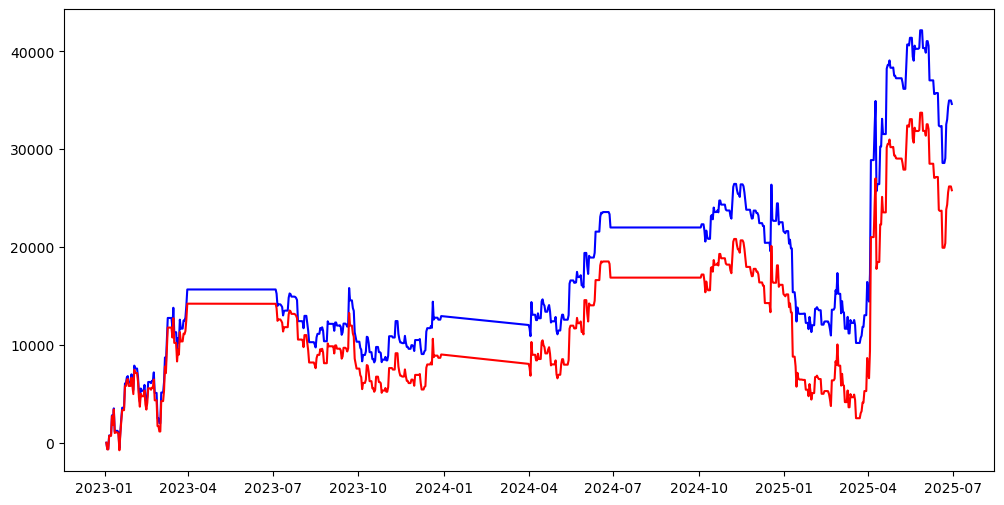

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(gross_all.fillna(0)), label = 'Gross PnL', color='blue')
plt.plot(np.cumsum(net_all.fillna(0)), label = 'Net PnL', color='red')
plt.title('Cumulative Gross and Net PnL')
plt.legend()
plt.grid(axis='x')

plt.savefig(f"data1_{quarter}.png", dpi = 300, bbox_inches = "tight")
plt.close()